In [1]:
# General use
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import uuid

# News-handling utilities
import newspaper
from bs4 import BeautifulSoup
import requests
from lib.utils.url_parsers import extract_host, extract_headline, extract_article_artifacts

# Notebook behavior
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
seed = 19  # Replicability

In [2]:
# Load data
df = pd.read_csv("../data/bq-results-20240316-113951-1710589244204.csv", dtype={"GLOBALEVENTID":str, "MentionIdentifier":str, "QuadClass":str, "CAMEOEventRoot":str, "CAMEOEventBase":str, "CAMEOEvent":str})
df = pd.DataFrame({"uuid":[uuid.uuid4() for _ in range(len(df))]}).merge(df, left_index=True, right_index=True).set_index("uuid", drop=True)
df.shape
df.head()

(1018675, 35)

,GLOBALEVENTID,SQLDATE,FractionDate,EventTimeDate,QuadClass,CAMEOEventRoot,CAMEOEventBase,CAMEOEvent,GoldsteinScore,Actor1Code,...,MentionIdentifier,IsRootEvent,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone
uuid,,,,,,,,,,,,,,,,,,,,,
aeb83aff-86d4-4808-8e90-ac3d27d5a464,1164103006,20240316,2024.2082,20240316081500,1,01,013,013,0.4,MYS,...,https://www.rappler.com/life-and-style/food-dr...,1,3,1169,1210,1180,0,10,7331,3.430962
0bd5e51a-2dc9-4428-8ece-8eee0fd05464,1164102494,20240316,2024.2082,20240316081500,1,05,051,051,3.4,AFR,...,https://www.sunstar.com.ph/cebu/maximum-mindse...,1,3,1518,1621,1527,0,20,5466,2.898551
e4c78601-543c-48ae-af1f-030ccbb59ad8,1164060456,20240316,2024.2082,20240316004500,1,01,014,014,0.0,JUDJUD,...,https://mb.com.ph/2024/3/16/new-york-judge-del...,0,8,2479,2527,2513,1,20,2959,-7.831325
6e374367-9888-4a9c-8844-2700c67f380a,1164063019,20240316,2024.2082,20240316010000,1,04,043,043,2.8,USA,...,https://mb.com.ph/2024/3/16/biden-praises-us-s...,0,21,3472,3424,3459,0,20,3662,-0.978793
ddd14a13-71af-4e0b-a193-fcd8dc485be6,1164052553,20240316,2024.2082,20240316000000,4,19,190,190,-10.0,RUSGOV,...,https://globalnation.inquirer.net/228364/putin...,1,2,459,567,553,0,20,5240,-4.127358


In [3]:
# Create dataframe for unique documents
docs = df[["MentionIdentifier"]].drop_duplicates().reset_index(drop=True)

# Derive news outlet
docs["DocNewsOutlet"] = docs["MentionIdentifier"].str.upper().apply(extract_host)
docs["DocNewsOutlet"].value_counts(normalize=True, dropna=False)

DocNewsOutlet
INQUIRER           0.187553
PHILSTAR           0.155424
MANILATIMES        0.129269
BUSINESSMIRROR     0.125877
MB                 0.074624
TRIBUNE            0.067218
CNNPHILIPPINES     0.059676
RAPPLER            0.051059
PHILIPPINETIMES    0.048301
SUNSTAR            0.046696
BWORLDONLINE       0.042611
GMANETWORK         0.011692
Name: proportion, dtype: float64

In [4]:
%%time
n = 100
grouped_samples = docs.groupby("DocNewsOutlet")["MentionIdentifier"].agg(lambda ser: sorted(ser.tolist())[:n])
res = {}
for group in grouped_samples.index:
    print(group)
    samples = grouped_samples[group]
    res[group] = {sample:extract_article_artifacts(sample) for sample in samples}

BUSINESSMIRROR
BWORLDONLINE
CNNPHILIPPINES
GMANETWORK
INQUIRER
MANILATIMES
MB
PHILIPPINETIMES
PHILSTAR
RAPPLER
SUNSTAR
TRIBUNE
CPU times: user 1min 54s, sys: 3.66 s, total: 1min 57s
Wall time: 25min 44s


<Axes: ylabel='NewsOutlet'>

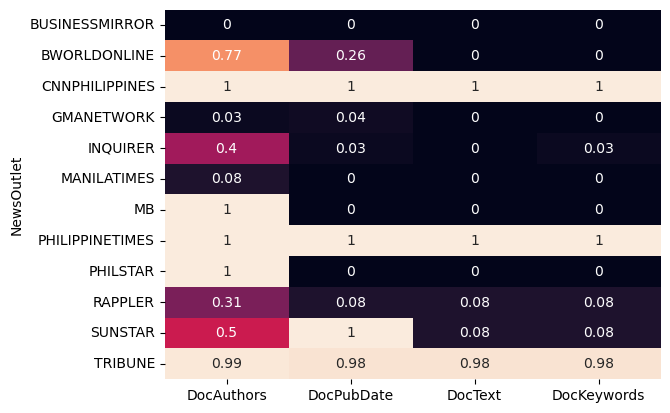

In [5]:
# Check for sparsity
res_df = pd.concat([pd.DataFrame.from_dict(res[group], orient="index") for group in grouped_samples.index], axis=0)
res_df["NewsOutlet"] = res_df.index.str.upper().map(extract_host)
res_df["DocAuthors"] = res_df["DocAuthors"].apply(lambda x: np.nan if x==[] else x)
res_df["DocKeywords"] = res_df["DocKeywords"].apply(lambda x: np.nan if x==[] else x)

tmp = res_df.groupby("NewsOutlet")[["DocAuthors", "DocPubDate", "DocText", "DocKeywords"]].agg(lambda ser: ser.isna().mean())
sns.heatmap(tmp, annot=True, cbar=False)

In [6]:
# Approximately how many docs are scraped?
unscraped_outlets = ["CNNPHILIPPINES", "PHILIPPINETIMES", "PHILSTAR", "TRIBUNE"]
(~docs["DocNewsOutlet"].isin(unscraped_outlets)).sum()

103398

In [7]:
# Check samples for quality
for group in grouped_samples.index:
    if group not in unscraped_outlets:
        res_df[res_df["NewsOutlet"]==group].sample(n=30, random_state=seed)

,DocAuthors,DocPubDate,DocText,DocKeywords,NewsOutlet
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/05/08/stock-market-outlook-55/,"[Var Molongui_Authorship_Byline_Params, Byline...",2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"[children, care, store, shoppers, share, kingd...",BUSINESSMIRROR
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/02/27/stock-market-outlook-46/,"[Var Molongui_Authorship_Byline_Params, Byline...",2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"[children, care, store, shoppers, share, kingd...",BUSINESSMIRROR
https://businessmirror.com.ph/2018/02/19/south-korea-joins-us-thailand-in-military-drill/,"[The Associated Press, Var Molongui_Authorship...",2018-02-19 00:00:00,"SATTAHIP, Thailand—Troops from South Korea joi...","[drill, exercise, thai, landing, taking, thail...",BUSINESSMIRROR
https://businessmirror.com.ph/2018/04/09/corruption-in-2018-will-we-see-change/,"[Henry J. Schumacher, Var Molongui_Authorship_...",2018-04-09 00:00:00,"Over the last two years, scandals unveiled by ...","[action, international, ogp, anticorruption, g...",BUSINESSMIRROR
https://businessmirror.com.ph/2015/02/20/enactment-of-tax-reform-measures-seen-this-year/,"[Philippines News Agency, Var Molongui_Authors...",2015-02-20 00:00:00,The Tax Management Association of the Philippi...,"[tax, measures, congress, base, incometax, cou...",BUSINESSMIRROR
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2018/09/25/money-laundering-as-part-of-corruption-is-blooming/,"[Var Molongui_Authorship_Byline_Params, Byline...",2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"[children, care, store, shoppers, share, kingd...",BUSINESSMIRROR
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/05/21/pcaarrds-innovative-projects-featured-in-international-meet/,"[Var Molongui_Authorship_Byline_Params, Byline...",2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"[children, care, store, shoppers, share, kingd...",BUSINESSMIRROR
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2018/02/05/lion-dance-in-singapore-ahead-of-lunar-new-year/,"[Var Molongui_Authorship_Byline_Params, Byline...",2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"[children, care, store, shoppers, share, kingd...",BUSINESSMIRROR
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/05/05/what-to-know-about-king-charles-iiis-coronation/,"[Var Molongui_Authorship_Byline_Params, Byline...",2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"[children, care, store, shoppers, share, kingd...",BUSINESSMIRROR
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2021/10/18/8-tips-for-conducting-an-excellent-remote-interview/,"[Var Molongui_Authorship_Byline_Params, Byline...",2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"[children, care, store, shoppers, share, kingd...",BUSINESSMIRROR


,DocAuthors,DocPubDate,DocText,DocKeywords,NewsOutlet
https://www.bworldonline.com/arts-and-leisure/2023/02/28/507098/summer-mmff-pushing-through-8-entries-announced/,[Joseph Emmanuel Garcia],2023-02-28 00:00:00,1 of 8\n\nA CRIME drama from Brillante Mendoza...,"[mmff, film, summer, festival, theaters, entri...",BWORLDONLINE
https://www.bworldonline.com/arts-and-leisure/2023/02/16/504994/croatian-restaurant-offers-one-pot-menu-cooked-by-robotic-chef/,[Joseph Emmanuel Garcia],2023-02-16 00:00:00,"ZAGREB — Craving gnocchi with lamb, black riso...","[croatian, cooked, food, bujas, robot, pot, mr...",BWORLDONLINE
https://www.bworldonline.com/?blackhole=a1b062e40e,NaN,NaT,We should be positively stoked about the state...,"[state, online, realize, pun, ev, shocking, ma...",BWORLDONLINE
https://www.bworldonline.com/?blackhole=b032f3b620,NaN,NaT,We should be positively stoked about the state...,"[state, online, realize, pun, ev, shocking, ma...",BWORLDONLINE
https://www.bworldonline.com/?blackhole=05986acdb2,NaN,NaT,We should be positively stoked about the state...,"[state, online, realize, pun, ev, shocking, ma...",BWORLDONLINE
https://www.bworldonline.com/arts-and-leisure/2023/01/05/496470/celebrate-the-feast-of-the-three-kings-at-the-pen/,NaN,2023-01-05 00:00:00,"FOR many people, the Christmas holidays end wi...","[peninsula, spanish, pen, visit, noon, present...",BWORLDONLINE
https://www.bworldonline.com/arts-and-leisure/2023/03/02/507781/talaba-grill-festival-makes-a-comeback-in-zamboanga-sibugay/,[Joseph Emmanuel Garcia],2023-03-02 00:00:00,THE TALABA Grill Festival returned to Zamboang...,"[festival, provinces, zamboanga, grill, talaba...",BWORLDONLINE
https://www.bworldonline.com/agribusiness/2023/04/24/518533/eu-plans-farmer-support-import-curbs-on-ukraine-grain/,NaN,2023-04-24 00:00:00,BRUSSELS — The European Union (EU) is preparin...,"[eu, farmer, imports, ukrainian, poland, commi...",BWORLDONLINE
https://www.bworldonline.com/arts-and-leisure/2023/02/24/506782/ex-producer-harvey-weinstein-sentenced-to-16-years-on-la-rape-conviction/,[Jino Nicolas],2023-02-24 00:00:00,"– Harvey Weinstein, the onetime Hollywood tita...","[16, sentenced, sexual, judge, weinstein, cour...",BWORLDONLINE
https://www.bworldonline.com/arts-and-leisure/2023/02/09/503693/a-sweet-taste-of-japan/,NaN,2023-02-09 00:00:00,"1 of 3\n\nSORRY, ladies. In Japan, apparently,...","[products, makoto, sweet, hokkaido, world, wom...",BWORLDONLINE


,DocAuthors,DocPubDate,DocText,DocKeywords,NewsOutlet
https://www.gmanetwork.com/news/money/companies/865180/bdo-to-buy-out-keppel-group-s-stake-in-podium-complex/story/,"[Jon Viktor D. Cabuenas, Gma Integrated News, ...",2023-03-27 18:01:41+08:00,Sy-led BDO Unibank Inc. is set to buy out the ...,"[keppel, net, bdo, transaction, value, smkl, i...",GMANETWORK
https://www.gmanetwork.com/news/lifestyle/travel/870252/dot-dict-to-improve-internet-connectivity-in-94-tourist-destinations/story/,"[Gma Integrated News, Compare Storyparsed.Auth...",2023-05-16 20:29:20+08:00,Tourists may soon enjoy better internet connec...,"[philippines, world, tourism, slogan, 94, best...",GMANETWORK
https://www.gmanetwork.com/news/lifestyle/artandculture/895319/manila-international-book-fair-reveals-dates-for-2024-edition/story/,"[Gma Integrated News, Compare Storyparsed.Auth...",2024-01-25 10:31:33+08:00,Mark the dates bookworms! Manila International...,"[international, yapla, wurtzbach, 2024, reveal...",GMANETWORK
https://www.gmanetwork.com/news/lifestyle/artandculture/897801/iti-mapukpukaw-and-gitling-to-compete-at-the-2024-osaka-asian-film-festival/story/,"[Gma Integrated News, Compare Storyparsed.Auth...",2024-02-17 18:19:57+08:00,Filipino films “Iti Mapukpukaw” and “Gitling” ...,"[gma, philippines, film, festival, gitling, 20...",GMANETWORK
https://www.gmanetwork.com/lifestyle/infocus/a-techpreneur-through-and-through,NaN,NaT,People all have something they are passionate ...,"[philippines, business, brian, world, way, vir...",GMANETWORK
https://www.gmanetwork.com/news/lifestyle/food/876265/makati-s-the-curator-among-asia-s-50-best-bars-of-2023/story/,"[Gma Integrated News, Compare Storyparsed.Auth...",2023-07-19 12:13:53+08:00,Asia’s 50 Best Bars released its annual list f...,"[philippines, 2023, spotthe, bars, makati, bes...",GMANETWORK
https://www.gmanetwork.com/news/money/companies/867329/fuel-surcharges-for-may-flights-lowered/story/,"[Ted Cordero, Gma Integrated News, Compare Sto...",2023-04-18 20:25:22+08:00,Travelers may expect lower airfares as the Civ...,"[lowered, philippines, fuel, passengers, range...",GMANETWORK
https://www.gmanetwork.com/news/lifestyle/content/895356/why-teach-taylor-swift-up-prof-explains/story/,"[Gma Integrated News, Compare Storyparsed.Auth...",2024-01-25 15:51:32+08:00,"Dr. Cherish Brillon, the professor who will te...","[prof, pop, focus, explains, study, course, te...",GMANETWORK
https://www.gmanetwork.com/news/lifestyle/travel/898301/4-places-in-the-philippines-you-can-visit-for-a-sakura-esque-experience/story/,"[Gma Integrated News, Compare Storyparsed.Auth...",2024-02-22 16:10:01+08:00,Sakura season is almost upon us!\n\n\n\nThe pl...,"[philippines, pink, palawan, sakuraesque, expe...",GMANETWORK
https://www.gmanetwork.com/news/lifestyle/hobbiesandactivities/888488/shamcey-supsup-calls-off-trip-to-el-salvador-for-miss-universe-will-be-cheering-for-michel/story/,"[Gma Integrated News, Compare Storyparsed.Auth...",2023-11-15 19:26:06+08:00,National Director for Miss Universe Philippine...,"[philippines, michelle, 2023, supsup, el, univ...",GMANETWORK


,DocAuthors,DocPubDate,DocText,DocKeywords,NewsOutlet
https://business.inquirer.net/383696/u-s-treasury-activates-another-maneuver-to-avoid-breaching-debt-limit,NaN,2023-01-25 10:10:37+08:00,WASHINGTON – U.S. Treasury Secretary Janet Yel...,"[activates, reinvestments, debt, limit, ceilin...",INQUIRER
https://business.inquirer.net/383100/3-rcep-conditionalities-unmet,[Ernesto M. Ordoñez],2023-01-20 02:12:00+08:00,There are three conditionalities for the Regio...,"[agriculture, private, sectors, representative...",INQUIRER
https://business.inquirer.net/380480/russia-risks-causing-new-year-it-worker-flight-with-remote-working-law,NaN,2023-01-02 15:30:15+08:00,MOSCOW – Russia’s buffetted IT sector risks lo...,"[russian, worker, work, working, try, law, fli...",INQUIRER
https://business.inquirer.net/380524/peza-approves-creation-of-29-more-ecozones,[Alden M. Monzon],2023-01-03 02:08:00+08:00,The Philippine Economic Zone Authority (Peza) ...,"[philippines, zone, tourism, zones, peza, appr...",INQUIRER
https://bandera.inquirer.net/360502/mga-besh-knows-nyo-bang-may-bago-nang-guidelines-bago-mag-abroad,NaN,2023-08-26 11:39:15+08:00,"NAGBABALAK ba kayong mag-abroad?\n\nNako, kail...","[besh, aosg, guidelines, knows, bago, mga, ofw...",INQUIRER
https://business.inquirer.net/381618/factbox-the-10-biggest-u-s-retail-bankruptcies-in-5-years,NaN,2023-01-10 08:54:43+08:00,NEW YORK – Storied home goods chain Bed Bath &...,"[store, emerged, bankruptcies, retail, 2020, o...",INQUIRER
https://business.inquirer.net/383926/morgan-stanley-hit-employees-with-up-to-1m-in-penalties-for-messaging-breaches-ft,NaN,2023-01-26 14:56:48+08:00,Morgan Stanley has hit financial penalties on ...,"[hit, sec, 1m, stanley, messaging, ft, financi...",INQUIRER
https://business.inquirer.net/381077/unity-in-agriculture,[Ernesto M. Ordoñez],2023-01-06 02:16:18+08:00,"To address agriculture’s challenges in 2023, w...","[cacao, agriculture, technology, private, sect...",INQUIRER
https://business.inquirer.net/383665/probe-of-illegal-sale-of-palm-olein-set,[Jordeene B. Lagare],2023-01-25 02:10:00+08:00,President Marcos has directed the Department o...,"[sale, oil, illegal, olein, coconut, palm, fee...",INQUIRER
https://business.inquirer.net/382791/explore-the-world-again-with-the-new-explorer-credit-card-by-bdo-and-american-express,[Inquirer.Net Brandroom],2023-01-18 12:50:47+08:00,"BDO Unibank, Inc. and American Express have la...","[explorer, world, travel, express, points, car...",INQUIRER


,DocAuthors,DocPubDate,DocText,DocKeywords,NewsOutlet
https://www.manilatimes.net/2023/01/03/news/trough-of-lpa-brings-rainin-visayas-mindanao-palawan/1872598,[Arlie O. Calalo],2023-01-03 00:00:00,THE low pressure area (LPA) that is in the bou...,"[lpa, weather, palawan, responsibility, mindan...",MANILATIMES
https://www.manilatimes.net/2023/01/03/news/marcos-eyes-new-chapter-in-relations-with-china/1872625,[Catherine S. Valente Kristina Maralit Bernade...,2023-01-03 00:00:00,(UPDATE) DESPITE tension in the South China Se...,"[state, tension, visit, south, chapter, sea, u...",MANILATIMES
https://www.manilatimes.net/2023/01/01/opinion/columns/reforms-needed-in-the-afp/1872397,"[Maj. Gen. Edgard A. Arevalo, Ret.]",2023-01-01 00:00:00,"Part 2\n\nIN my Dec. 25, 2022 opinion piece, a...","[unchecked, ra, wrote, reforms, caused, early,...",MANILATIMES
https://www.manilatimes.net/2023/01/02/business/top-business/meralco-airport-glitch-not-our-fault/1872486,[Ed Paolo Salting],2023-01-02 00:00:00,MANILA Electric Co. (Meralco) on Sunday said i...,"[occurred, fault, reroutings, outages, naiait,...",MANILATIMES
https://www.manilatimes.net/2023/01/01/business/sunday-business-it/adopting-modern-integration-solution/1872338,[David Irecki],2023-01-01 00:00:00,DRIVING innovation through data is essential t...,"[data, businesses, organizations, solution, pe...",MANILATIMES
https://www.manilatimes.net/2023/01/02/news/regions/dswd-gives-p281m-aid-to-flood-victims/1872439,[Philippine News Agency],2023-01-02 00:00:00,CAGAYAN DE ORO CITY: The Department of Social ...,"[p281m, assistance, supervised, gives, dswd, s...",MANILATIMES
https://www.manilatimes.net/2023/01/03/news/world/colombia-strikes-ceasefire-deal-with-main-armed-groups/1872508,[Agence France-Presse],2023-01-03 00:00:00,"Bogotá, Colombia: Colombia's government has ag...","[truce, total, sixmonth, president, colombia, ...",MANILATIMES
https://www.manilatimes.net/2023/01/02/news/national/firecracker-related-injuries-down/1872467,[Moises Cruz],2023-01-02 00:00:00,THE Department of Health (DoH) recorded 137 in...,"[firecrackerrelated, rosario, provided, nation...",MANILATIMES
https://www.manilatimes.net/2023/01/03/news/robredo-heading-home-after-us-stint/1872616,[Aric John Sy Cua],2023-01-03 00:00:00,"FORMER vice president Ma. Leonor ""Leni"" Robred...","[vice, post, heading, wrote, president, robred...",MANILATIMES
https://www.manilatimes.net/2023/01/02/public-square/pagcor-warns-public-against-illegal-online-gambling/1872465,NaN,2023-01-02 00:00:00,THE Philippine Amusement and Gaming Corporatio...,"[scammed, online, states, pagcor, public, take...",MANILATIMES


,DocAuthors,DocPubDate,DocText,DocKeywords,NewsOutlet
https://mb.com.ph/2023/01/01/with-naia-glitch-fixed-what-happens-next-miaa-counts-the-ways-to-help-stranded-passengers/,NaN,2023-01-01 00:00:00,Now that the operations at the Ninoy Aquino In...,"[companies, international, counts, chiong, pas...",MB
https://mb.com.ph/2023/01/01/new-year-celebration-in-bulacan-peaceful-and-safe-police/,NaN,2023-01-01 00:00:00,The New Year celebration in the province of Bu...,"[province, peaceful, safe, pandi, tupada, san,...",MB
https://mb.com.ph/2021/2/16/why-rizal-loved-the-czechs,NaN,2021-02-16 00:00:00,And how Czech Ambassador Jana Šedivá’s courtes...,"[philippines, republic, jana, czech, ambassado...",MB
https://mb.com.ph/2021/2/23/mounting-tensions-in-scs,NaN,2021-02-23 00:00:00,CHAFF FROM THE GRAIN\n\n“Asia-Pacific countrie...,"[singapore, mounting, states, lee, president, ...",MB
https://mb.com.ph/2019/06/07/big-time-oil-price-rollback-set/,NaN,2019-06-07 00:00:00,,[article],MB
https://mb.com.ph/2021/7/5/method-race-wheels-to-be-distributed-by-wheel-gallery,NaN,2021-07-05 00:00:00,Off-roaders can venture further than before wh...,"[gallery, race, method, technology, grip, bead...",MB
https://mb.com.ph/2023/01/02/3-injured-in-lpg-tank-explosion-in-pasig-city/,NaN,2023-01-02 00:00:00,Three individuals sustained injuries after an ...,"[bfp, city, capistrano, burns, sustained, indi...",MB
https://mb.com.ph/2021/6/22/korean-embassy-in-ph-says-sokor-govt-to-discuss-situation-of-stranded-pinoy-eps-workers,NaN,2021-06-22 00:00:00,The Korean government will discuss with govern...,"[philippines, visa, sokor, korean, eps, pinoy,...",MB
https://mb.com.ph/2023/01/01/ukraine-will-fight-until-victory-zelensky/,NaN,2023-01-01 00:00:00,"KYIV, Ukraine - Ukraine will fight the Russian...","[russian, wave, country, world, wounded, war, ...",MB
https://mb.com.ph/2023/01/01/children-among-nine-dead-in-uganda-new-year-stampede/,NaN,2023-01-01 00:00:00,"KAMPALA, Uganda - At least nine people died, m...","[children, mall, kampala, stampede, spokesman,...",MB


,DocAuthors,DocPubDate,DocText,DocKeywords,NewsOutlet
https://www.rappler.com/brandrap/jollibee-group-san-miguel-foods-partnership-2023/,"[Marj Casal, Brandrap Team]",2023-09-08 06:39:55+00:00,"This is AI generated summarization, which may ...","[companies, food, group, jfc, nourish, quality...",RAPPLER
https://www.rappler.com/brandrap/fudgee-barr-korean-inspired-flavors-citron-tea-dalgona-blueberry-yoghurt/,"[Saab Lariosa, Brandrap Team]",2024-03-05 03:13:28+00:00,"This is AI generated summarization, which may ...","[including, fudgee, releases, koreaninspired, ...",RAPPLER
https://nowyouknowph.rappler.com/598/world-visions-project-ace-lgu-partners-celebrate-wins-and-lessons-in-cdo/,[World Vision],2023-04-03 09:00:00+00:00,[#PressRelease]\n\nOne year after their joint ...,"[children, cdo, lgu, including, world, project...",RAPPLER
https://nowyouknowph.rappler.com/685/pressrelease-philippine-korean-youth-forum-returns-better-bolder-on-its-3rd-year/,[Mai Mercado],2023-06-18 23:30:00+00:00,"Over the years, the Philippines, South Korea, ...","[returns, philippines, pkyf, philippinekorean,...",RAPPLER
https://btf.rappler.com/237/asean-foundation-with-support-from-google-org-held-asean-digital-literacy-programme-impact-forum-and-launched-a-digital-literacy-e-learning-platform-on-global-media-and-information-literacy-we/,[Gabriel Billones Jr],2023-11-22 17:12:56+00:00,"Bali, Indonesia, November 15, 2023 – On Global...","[literacy, dlp, asean, local, week, digital, p...",RAPPLER
https://scoutmediaph.rappler.com/being-a-hero-of-the-people/,NaN,NaT,NaN,NaN,RAPPLER
https://www.rappler.com/brandrap/nextstop-qingtiangang-grassland/,[Saab Lariosa],2023-07-22 03:40:00+00:00,Check out this tour that shows Taiwan in a new...,"[amazing, world, bustle, grassland, area, book...",RAPPLER
https://nowyouknowph.rappler.com/821/sm-store-launches-initiative-to-support-indigent-farmers-in-mindanao/,NaN,2023-09-13 00:33:09+00:00,Published in partnership with PhilSEED\n\nZAMB...,"[initiative, store, farming, indigent, mindana...",RAPPLER
https://www.rappler.com/brandrap/international-environmental-education-day-january-26-2024/,"[Saab Lariosa, Brandrap Team]",2024-01-26 01:00:00+00:00,"This is AI generated summarization, which may ...","[bigger, international, environmental, little,...",RAPPLER
https://www.rappler.com/brandrap/beneficiaries-experiences-stories-having-insurance/,"[Marj Casal, Brandrap Team]",2024-03-05 06:14:23+00:00,"This is AI generated summarization, which may ...","[financial, santos, insurance, able, let, mr, ...",RAPPLER


,DocAuthors,DocPubDate,DocText,DocKeywords,NewsOutlet
https://www.sunstar.com.ph/article/1950363/pampanga/opinion/cervantes-tech-to-create-sky-images-to-lead-you-down-the-path-contrary-to-the-divine-will,[Ding Cervantes],NaN,The destruction of the Twin Towers in New York...,"[faith, king, mother, come, create, lead, son,...",SUNSTAR
https://www.sunstar.com.ph/article/1950296/manila/local-news/over-6000-queue-for-pagpupugay-day-1,NaN,NaN,"IN JUST the first 15 hours of the ""Pagpupugay,...","[church, wipe, pagpupugay, queue, image, quiap...",SUNSTAR
https://www.sunstar.com.ph/article/1949927/cebu/business/foreign-tourists-in-ph-reach-265m-in-2022,[Carlo Lorenciana],NaN,INTERNATIONAL tourist arrivals in the Philippi...,"[philippines, international, tourism, frasco, ...",SUNSTAR
https://www.sunstar.com.ph/article/1949969/network/world/apollo-7-astronaut-walter-cunningham-dead-at-90,NaN,NaN,"Walter Cunningham, the last surviving astronau...","[mission, cunningham, walter, astronaut, space...",SUNSTAR
https://www.sunstar.com.ph/article/1949842/manila/local-news/cbcp-remembers-offers-prayers-for-benedict-xvi,NaN,NaN,THE Catholic Bishops’ Conference of the Philip...,"[philippines, xvis, remembers, remember, bened...",SUNSTAR
https://www.sunstar.com.ph/article/1950131/cebu/business/ph-china-ink-tourism-implementation-deal,NaN,NaN,THE Department of Tourism (DOT) and its counte...,"[philippines, products, program, tourism, fras...",SUNSTAR
https://www.sunstar.com.ph/article/1950383/manila/local-news/new-cidg-director-installed,[Third Anne Peralta-Malonzo],NaN,A NEW director of the Criminal Investigation a...,"[try, group, siguro, director, mga, installed,...",SUNSTAR
https://www.sunstar.com.ph/article/1950067/davao/local-news/spmc-readies-for-possible-covid-19-surge,[Ralph Lawrence G. Llemit],NaN,Audan said that while Covid-19 cases in the ho...,"[covid19, possible, rooms, spmc, readies, safe...",SUNSTAR
https://www.sunstar.com.ph/article/1950337/tacloban/local-news/eastern-visayas-logs-2-covid-deaths-1-critical-case,[Ronald O. Reyes],NaN,AT LEAST two patients died and another is in c...,"[covid19, health, total, case, patients, death...",SUNSTAR
https://www.sunstar.com.ph/article/1950204/cebu/business/trade-chief-encourages-foreign-firms-to-invest-in-ph-renewable-sector,[Carlo Lorenciana],NaN,TRADE Secretary Fred Pascual has trumpeted the...,"[philippines, firms, renewable, trade, chief, ...",SUNSTAR


<div class="alert alert-block alert-info">
    <ul>
        <li><b>BUSINESSMIRROR</b> Repeated SM links. Evaluate if the second part of link is the correct one relative to associated events.</li>
        <li><b>BWORLDONLINE</b> Blackhole links redirect to homepage, can be removed.</li>
        <li><b>GMANETWORK</b> No apparent issue.</li>
        <li><b>INQUIRER</b> No apparent issue.</li>
        <li><b>MANILATIMES</b> No apparent issue.</li>
        <li><b>MB</b> No apparent issue.</li>
        <li><b>RAPPLER</b> Repeating first paragraph. Keywords still vary.</li>
        <li><b>SUNSTAR</b> No apparent issue.</li>
        <li>Encountered difficulty scraping from <b>CNNPHILIPPINES</b>, <b>PHILIPPINETIMES</b>, <b>PHILSTAR</b>, <b>TRIBUNE</b>. Additionally, <b>CNNPHILIPPINES</b> can be removed because they shut down operations January 31, 2024.</li>
    </ul>
</div>


## PHILSTAR

In [8]:
# Assert all patterns are known
N = (docs["DocNewsOutlet"]=="PHILSTAR").sum()
interaksyon_pat = docs[(docs["DocNewsOutlet"]=="PHILSTAR") & (docs["MentionIdentifier"].str.contains("interaksyon"))]
philstar_pat = docs[(docs["DocNewsOutlet"]=="PHILSTAR") & (docs["MentionIdentifier"].str.contains("www\.philstar\.com"))]
qa_pat = docs[(docs["DocNewsOutlet"]=="PHILSTAR") & (docs["MentionIdentifier"].str.contains("qa\.philstar\.com"))]
assert (interaksyon_pat.shape[0] + philstar_pat.shape[0] + qa_pat.shape[0]) == N

In [9]:
# Attempt to scrape using tool
extract_article_artifacts(interaksyon_pat["MentionIdentifier"].values[0])
extract_article_artifacts(philstar_pat["MentionIdentifier"].values[0])
extract_article_artifacts(qa_pat["MentionIdentifier"].values[0])

{'DocAuthors': [],
 'DocPubDate': datetime.datetime(2024, 3, 15, 0, 0),
 'DocText': 'The American aerospace giant Boeing has been synonymous with safe air travel for decades. Since the 1990s, Boeing and its European competitor Airbus have dominated the market for large passenger jets.\n\nBut this year, Boeing has been in the news for all the wrong reasons. In January, an emergency door plug blew off a Boeing 737 MAX in mid flight, triggering an investigation from United States federal regulators.\n\nMore recently, we have seen a Boeing plane lose a tyre while taking off, another flight turned back as the plane was leaking fluid, an apparent engine fire, a landing gear collapse, a stuck rudder pedal, and a plane “dropping” in flight and injuring dozens of passengers. A Boeing engineer who had raised concerns regarding quality control during the manufacturing process on the company’s 787 and 737 MAX planes also died earlier this week, apparently of a self-inflicted gunshot wound.\n\nAs m

{'DocAuthors': ['Agence France-Presse'],
 'DocPubDate': datetime.datetime(2024, 3, 16, 0, 0),
 'DocText': 'PALESTINIAN TERRITORIES — Senior figures from Hamas and Yemen\'s Huthi rebels held a rare meeting to discuss coordinating their actions against Israel, Palestinian factional sources told AFP on Friday.\n\nHamas and the Huthis belong to the "axis of resistance", a collection of Iran-backed movements hostile to Israel and the United States that also includes Lebanon\'s Hezbollah and Iraqi militias.\n\nThe Huthis have attacked Red Sea shipping for months since the Israel-Hamas war broke out on October 7, saying they are targeting Israeli-linked vessels in solidarity with Palestinians in Gaza.\n\nAccording to sources from Hamas and Islamic Jihad, leaders from the two Palestinian Islamist groups, as well as the Marxist Popular Front for the Liberation of Palestine, held an "important meeting" with Huthi representatives last week.\n\nThe groups discussed "mechanisms to coordinate their 

{'DocAuthors': ['Gaea Katreena Cabico'],
 'DocPubDate': datetime.datetime(2024, 3, 3, 0, 0),
 'DocText': 'Weak warnings, land use exacerbated impact of heavy rain in Mindanao — scientists\n\nView from an aerial inspection in Barangay Masara, Maco, Davao de Oro on February 7, 2024.\n\nMANILA, Philippines — Scientists found deforestation, settlements in danger zones, and inadequate warning systems were key factors in the deadly effects of heavy rainfall in Mindanao last February.\n\nHeavy rains brought by the northeast monsoon and a low-pressure trough caused massive floods and landslides across Mindanao last month, burying villages and leaving dozens dead.\n\nIn Brgy. Masara, a gold-mining village in Maco, Davao del Sur, landslides claimed 98 lives.\n\nAccording to a rapid analysis by climate scientists from the World Weather Attribution, heavy rainfall events are now dumping 50% more rain in Mindanao.\n\nHowever, they pointed out that while the February rainfall was “unseasonably heavy

In [10]:
# Try to build newspaper corpus
interaksyon_paper = newspaper.build("https://interaksyon.philstar.com")
philstar_paper = newspaper.build("https://www.philstar.com")
qa_paper = newspaper.build("https://qa.philstar.com")
papers = [interaksyon_paper, philstar_paper, qa_paper]

newspaper.news_pool.set(papers, threads_per_source=2) # (3*2) = 6 threads total
newspaper.news_pool.join()

In [11]:
# Use requests
source = requests.get(interaksyon_pat["MentionIdentifier"].values[0]).text
soup = BeautifulSoup(source, 'lxml')
str(soup).split("<")

['',
 '!DOCTYPE html>\n',
 '!--[if IE 8]>',
 'html class="ie8" lang="en-US" prefix="og: http://ogp.me/ns#"> ',
 '![endif]-->',
 '!--[if IE 9]>',
 'html class="ie9" lang="en-US" prefix="og: http://ogp.me/ns#"> ',
 '![endif]-->',
 '!--[if gt IE 8]>',
 '!-->',
 'html lang="en-US" prefix="og: http://ogp.me/ns#"> ',
 '!--',
 '![endif]-->',
 'head>',
 'link as="style" href="https://fonts.googleapis.com/css?family=Roboto+Condensed%3A300%2C300italic%2C400%2C400italic%2C700%2C700italic%2C800%2C900%7CRaleway%3A400%2C700%2C800%2C900%7CRadley%3A400%2C700%2C800%2C900%7COpen+Sans%3A300%2C400%2C600%2C700%2C800%2C900&amp;display=swap" id="ao_optimized_gfonts" onload="this.onload=null;this.rel=\'stylesheet\'" rel="preload"/>',
 'link href="https://interaksyon.philstar.com/wp-content/cache/autoptimize/css/autoptimize_a1b9ac053cf8934eec3bc390011cf519.css" media="all" rel="stylesheet"/>',
 'title>Should you be concerned about flying on Boeing planes?',
 '/title>',
 'meta charset="utf-8"/>',
 'meta content

In [12]:
# Add column to signal invalid docs
docs.loc[docs.query('(DocNewsOutlet=="PHILSTAR")').index, "Invalid"] = True

## BUSINESSMIRROR

In [13]:
# How much of in-scope docs have this pattern
sm_substring = "share-a-toy-at-the-sm-store"
docs[docs["DocNewsOutlet"]=="BUSINESSMIRROR"]["MentionIdentifier"].str.contains(sm_substring).mean()

0.4470787903723514

In [14]:
# Check for patterns
subset = docs[(docs["DocNewsOutlet"]=="BUSINESSMIRROR") & (docs["MentionIdentifier"].str.contains(sm_substring))]
subset["MentionIdentifier"].str[:75].value_counts()

MentionIdentifier
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=    8692
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/             1
Name: count, dtype: int64

In [15]:
# Clean links using regex
import re
pat = re.escape("https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=")
docs.loc[
    docs.query('(DocNewsOutlet=="BUSINESSMIRROR") & (MentionIdentifier.str.contains(@pat))').index, "CleanedMentionIdentifier"
    ] = docs.loc[
        docs.query('(DocNewsOutlet=="BUSINESSMIRROR") & (MentionIdentifier.str.contains(@pat))').index, "MentionIdentifier"
        ].str.replace(rf"^({pat})", "", regex=True).str.replace("https:/", "https://")
docs["CleanedMentionIdentifier"].dropna().values[0]
extract_article_artifacts(docs["CleanedMentionIdentifier"].dropna().values[0])

'https://businessmirror.com.ph/2023/06/02/ilijan-natgas-plant-reopens-starts-power-delivery-to-the-grid-doe/'

{'DocAuthors': ['Lenie Lectura',
  'Var Molongui_Authorship_Byline_Params',
  'Byline_Prefix',
  'Byline_Suffix',
  'Byline_Separator',
  'Byline_Last_Separator',
  'Byline_Link_Title',
  'View All Posts By',
  'Byline_Link_Class',
  'Byline_Dom_Tree'],
 'DocPubDate': datetime.datetime(2023, 6, 2, 0, 0),
 'DocText': 'THE 1,200-megawatt (MW) Ilijan natural gas plant has started delivering power to the grid, the Department of Energy (DOE) announced.\n\nThis after Linseed Field Corporation has successfully imported liquefied natural gas (LNG) and now supplies natural gas to the Ilijan plant.\n\n“With the delivery of LNG, Ilijan is now supplying power to the grid beginning yesterday, June 1, 2023 and is expected to improve its contribution to the energy supply in the Luzon grid, especially in the coming months,” said DOE in a statement issued Friday.\n\nSince June last year, the Ilijan plant has been on extended outage. It also underwent retrofitting works following the ceasing of gas supp

## BWORLDONLINE

In [16]:
# Check affected samples
docs.query('(DocNewsOutlet=="BWORLDONLINE") & (MentionIdentifier.str.contains("blackhole"))')

,MentionIdentifier,DocNewsOutlet,Invalid,CleanedMentionIdentifier
58998,https://www.bworldonline.com/?blackhole=245c98...,BWORLDONLINE,NaN,NaN
59044,https://www.bworldonline.com/?blackhole=f3710f...,BWORLDONLINE,NaN,NaN
60558,https://www.bworldonline.com/?blackhole=05986a...,BWORLDONLINE,NaN,NaN
72960,https://www.bworldonline.com/?blackhole=0555e4...,BWORLDONLINE,NaN,NaN
88100,https://www.bworldonline.com/?blackhole=c13517...,BWORLDONLINE,NaN,NaN
88713,https://www.bworldonline.com/?blackhole=74306f...,BWORLDONLINE,NaN,NaN
97775,https://www.bworldonline.com/?blackhole=b032f3...,BWORLDONLINE,NaN,NaN
98234,https://www.bworldonline.com/?blackhole=e351be...,BWORLDONLINE,NaN,NaN
98665,https://www.bworldonline.com/?blackhole=03d9a2...,BWORLDONLINE,NaN,NaN
98915,https://www.bworldonline.com/?blackhole=afce99...,BWORLDONLINE,NaN,NaN


In [17]:
# Add column to signal invalid docs
docs.loc[docs.query('(DocNewsOutlet=="BWORLDONLINE") & (MentionIdentifier.str.contains("blackhole"))').index, "Invalid"] = True

# Extract

In [18]:
# Prioritize new articts
recency = df.groupby("MentionIdentifier")["EventTimeDate"].max()
recency.name = "recency"
docs = docs.merge(recency, left_on="MentionIdentifier", right_index=True)
docs.sort_values("recency", ascending=False, inplace=True)

In [19]:
# Get doc_ids for scraping
# Limit date scope
docs["CleanedMentionIdentifier"] = docs["CleanedMentionIdentifier"].fillna(docs["MentionIdentifier"])
doc_ids = docs.query("(Invalid.isnull()) & (recency>=20230701000000)")["MentionIdentifier"].values.tolist()
len(doc_ids)

79639

%%time
from tqdm import tqdm
doc_res = {}
for doc_id in tqdm(doc_ids):
    doc_res[doc_id] = extract_article_artifacts(doc_id)
    if (doc_ids.index(doc_id) % 1000) == 0:
        pd.DataFrame.from_dict(doc_res, orient="index").to_csv("scraped_docs.csv")

# Preprocess

## Based on previous EDA

In [51]:
# Load scraped data
scraped = pd.read_csv(f"scraped_{len(doc_ids)}.csv", index_col="Unnamed: 0")
scraped.shape

(79639, 4)

In [52]:
# Extract outlet
scraped["DocOutlet"] = scraped.index.str.upper().map(extract_host)
scraped["DocOutlet"].value_counts(normalize=True, dropna=False)

DocOutlet
INQUIRER           0.237509
BUSINESSMIRROR     0.170708
MANILATIMES        0.134582
TRIBUNE            0.086905
CNNPHILIPPINES     0.070330
RAPPLER            0.069652
SUNSTAR            0.057547
MB                 0.056631
PHILIPPINETIMES    0.051206
BWORLDONLINE       0.049210
GMANETWORK         0.015721
Name: proportion, dtype: float64

In [53]:
# Exclude CNN and PHILIPPINETIMES
scraped = scraped[~scraped["DocOutlet"].isin(["CNNPHILIPPINES", "PHILIPPINETIMES"])]
scraped.shape

(69960, 5)

In [54]:
# Replace empty lists with nan
scraped.loc[scraped.query("DocAuthors=='[]'").index, "DocAuthors"] = np.nan
scraped.loc[scraped.query("DocKeywords=='[]'").index, "DocKeywords"] = np.nan

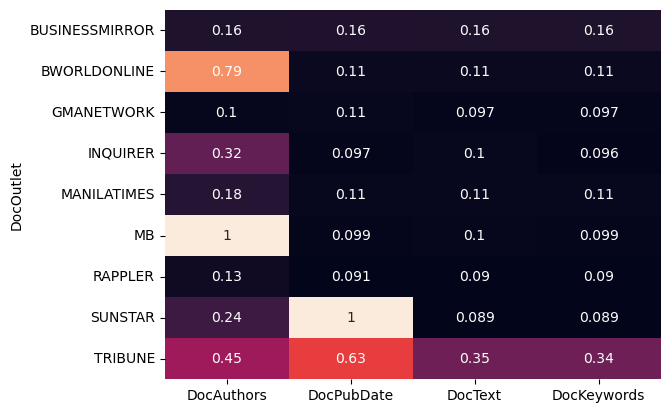

In [55]:
# Check sparsity
tmp = scraped.groupby("DocOutlet")[["DocAuthors", "DocPubDate", "DocText", "DocKeywords"]].agg(lambda ser: ser.isna().mean())
_ = sns.heatmap(tmp, annot=True, cbar=False)

## Clean RAPPLER DocText

In [65]:
# Find pattern
scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts()[:10]

DocText
This is AI generated summarization, which may have errors. For context, always refer to the full article.\n\n    4799
LIVE\n\nWith the world opening up, Kitchen 143 now heads out of the home kitchen and visits favorite restaura       6
LIVE\n\nKitchen 143 now heads out of the home kitchen and visits old and new favorite restaurants in and out        2
Founder of Break the Fake Movement, Gabriel Billones Jr., named as the first Filipino Obama Scholar at Colu         2
LIVE\n\nRappler Visayas Reporter John Sitchon speaks with victims and lawyers who are fighting the atrocities       2
Published in partnership with PhilSEED\n\nZAMBOANGA, PHILIPPINES. In line with its continuing commitment to c       2
In 'Maria,' Andes and her team journey with three women, all named Maria, who bear the brunt of former pres         1
Play Video\n\nThe families of Lee Sudario, 34, and Norman Ortiz, 25, together with human rights organization        1
The name Junaid Awal may not ring a bell for mos

In [73]:
# Clean doctext using pattern
pat = scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts().index[0]
scraped.loc[scraped.query("DocOutlet=='RAPPLER'").index, "DocText"] = scraped.loc[scraped.query("DocOutlet=='RAPPLER'").index, "DocText"].str.replace(pat, "")
scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts()[:10]  # Confim changes

DocText
LOWER HOUSE. The House of Representatives opens its second regular session on Monday morning, July 24, 2023      10
STAKING CLAIMS. A Philippine flag flutters from BRP Sierra Madre, a dilapidated Philippine Navy ship that h       8
LIVE\n\nWith the world opening up, Kitchen 143 now heads out of the home kitchen and visits favorite restaura     6
WATER CANNON. China uses water cannon again on Filipino ships in the West Philippine Sea, the Philippine Co       5
BLACKOUT. Residents and workers do their tasks under candlelight after a massive blackout hits Iloilo City        5
CHINA AND TAIWAN. Chinese and Taiwanese flags are seen through broken glass in this illustration taken, Apr       4
CONFISCATED. Police show a pistol, ammunition, and a grenade seized from from Allan Carcuevas in Bais City        4
NORTH KOREA. File photo shows the North Korean flag flies on a mast at the Permanent Mission of North Korea       4
ARTIFICIAL INTELLIGENCE. AI letters are placed on computer mothe

## By Feature

In [88]:
n = 2**4
samples = [scraped[scraped["DocOutlet"]==group].sample(n=n, random_state=seed) for group in scraped["DocOutlet"].unique()]

### DocAuthors

In [85]:
feature = "DocAuthors"
[display(sample[["DocOutlet", feature]]) for sample in samples]

,DocOutlet,DocAuthors
https://mb.com.ph/2024/1/9/davao-city-nets-p11-m-from-violators-in-2023,MB,NaN
https://mb.com.ph/2023/11/11/suspect-in-massacre-of-3-in-surigao-city-falls,MB,NaN
https://mb.com.ph/2023/11/23/p238-m-bangus-breeding-and-hatchery-facilities-to-rise-soon-in-pangasinan,MB,NaN
https://mb.com.ph/2024/1/14/p1-4-m-shabu-gun-seized-from-couple-in-drug-bust,MB,NaN
https://mb.com.ph/2023/11/6/ph-tells-eu-it-opposes-red-tagging-ej-ks,MB,NaN
https://mb.com.ph/2023/7/14/club-gymnastica-bets-dominate-challenge-2023,MB,NaN
https://mb.com.ph/2023/7/23/israel-s-netanyahu-to-be-fitted-with-pacemaker-haaretz-says,MB,NaN
https://mb.com.ph/2023/11/6/hamburg-airport-hostage-taker-gives-himself-up,MB,NaN
https://mb.com.ph/2023/12/07/city-of-manila-hailed-as-world-s-leading-city-destination-2023,MB,NaN
https://mb.com.ph/2024/1/3/3-npa-rebels-surrender-in-bukidnon,MB,NaN


,DocOutlet,DocAuthors
https://www.sunstar.com.ph/network/150-people-are-killed-in-gaza-in-24-hours-health-ministry-says,SUNSTAR,['Associated Press']
https://www.sunstar.com.ph/article/1973194/cebu/business/south-korean-products-to-flood-local-market,SUNSTAR,NaN
https://www.sunstar.com.ph/cebu/archbishop-villegas-priests-blessing-of-same-sex-couples-for-mercy-only,SUNSTAR,['Kaiser Jan Fuentes']
https://www.sunstar.com.ph/network/4-people-dead-in-msu-explosion,SUNSTAR,['Associated Press']
https://www.sunstar.com.ph/article/1974175/davao/business/davao-jinjiang-direct-flight-to-resume,SUNSTAR,"['Jeepy P. Compio', 'Ralph Lawrence Llemit']"
https://www.sunstar.com.ph/cebu/new-road-to-cebu-business-park-creek-rehab-eyed,SUNSTAR,['Earl Kim H. Padronia']
https://www.sunstar.com.ph/zamboanga/zamboanga-del-sur-gets-new-police-director,SUNSTAR,['Sunstar Zamboanga']
https://www.sunstar.com.ph/article/1972877/davao/local-news/jimenez-mindanao-could-be-an-island-of-hope-and-harmony,SUNSTAR,['David Ezra M. Francisquete']
https://www.sunstar.com.ph/zamboanga/westmincom-sends-off-ranger-battalion-for-retraining,SUNSTAR,['Sunstar Zamboanga']
https://www.sunstar.com.ph/manila/marcos-to-attendasean-japan-commemorative-summit,SUNSTAR,['Third Anne Peralta-Malonzo']


,DocOutlet,DocAuthors
https://www.rappler.com/life-and-style/food-drinks/pancit-malabon-canton-bihon-best-stir-fries-worldwide-taste-atlas-2023/,RAPPLER,['Steph Arnaldo']
https://www.rappler.com/world/middle-east/world-jewish-congress-head-calls-pope-francis-help-release-hostages/,RAPPLER,['Chito De La Vega']
https://www.rappler.com/world/middle-east/blinken-visits-west-bank-meet-palestinian-leader-abbas-gaza-war-rages/,RAPPLER,['Jairo Bolledo']
https://www.rappler.com/world/global-affairs/g7-support-ukraine-not-waver-due-middle-east-conflict/,RAPPLER,['Victor Barreiro Jr.']
https://www.rappler.com/newsbreak/inside-track/dan-fernandez-delivers-privilege-speech-theorizing-philippines-ophir-bible/,RAPPLER,"['Dwight De Leon', 'Dwight De Leon Is A Multim..."
https://www.rappler.com/philippines/livestream-japanese-prime-minister-fumio-kishida-addresses-philippine-congress-november-4-2023/,RAPPLER,['Patrick Santos']
https://www.rappler.com/brandrap/ways-choose-right-contraceptive/,RAPPLER,"['Marj Casal', 'Brandrap Team']"
https://www.rappler.com/world/middle-east/israel-war-hamas-updates-december-18-2023/,RAPPLER,['Victor Barreiro Jr.']
https://www.rappler.com/philippines/govt-ramps-up-rice-production-imports-el-nino-2024/,RAPPLER,"['Iya Gozum', 'Iya Gozum Covers The Environmen..."
https://www.rappler.com/entertainment/series/disney-bob-iger-reaches-out-striking-hollywood-creatives-respect/,RAPPLER,['Ysa Abad']


,DocOutlet,DocAuthors
https://www.gmanetwork.com/news/topstories/world/886594/looting-in-mexico-s-acapulco-after-devastating-hurricane-otis/story/,GMANETWORK,"['Alexandre Meneghini', 'Compare Storyparsed.A..."
https://www.gmanetwork.com/news/money/companies/877218/marcos-state-visit-in-malaysia-hastens-p3-b-investment-deal-for-railway-projects-romualdez/story/,GMANETWORK,"['Gma Integrated News', 'Compare Storyparsed.A..."
https://www.gmanetwork.com/news/topstories/world/880259/japan-says-china-s-harassment-calls-regarding-fukushima-water-release-extremely-regrettable/story/,GMANETWORK,"['Kiyoshi Takenaka', 'Compare Storyparsed.Auth..."
https://www.gmanetwork.com/news/cbb/content/885915/ccp-partners-with-philippine-pen-for-this-year-s-writers-congress/story/,GMANETWORK,"['Gma News', 'Compare Storyparsed.Author_Detai..."
https://www.gmanetwork.com/news/topstories/nation/884130/dilg-admits-911-hotline-still-quite-far-from-us-style/story/,GMANETWORK,"['Hana Bordey', 'Gma Integrated News', 'Compar..."
https://www.gmanetwork.com/news/topstories/world/894245/denmark-s-new-king-frederik-x-appears-before-parliament/story/,GMANETWORK,"['Jacob Gronholt-Pedersen', 'Stine Jacobsen', ..."
https://www.gmanetwork.com/news/topstories/nation/883398/dfa-confirms-azurin-held-by-canadian-immigration-authorities/story/,GMANETWORK,"['Llanesca T. Panti', 'Gma Integrated News', '..."
https://www.gmanetwork.com/news/topstories/regions/890767/asean-strongly-condemns-msu-bomb-attack/story/,GMANETWORK,['Compare Storyparsed.Author_Details.Parsed_By...
https://www.gmanetwork.com/news/topstories/world/889377/jewish-groups-criticize-pope-on-terrorism-remark-seek-clarification/story/,GMANETWORK,"['Philip Pullella', 'Compare Storyparsed.Autho..."
https://www.gmanetwork.com/news/topstories/nation/875438/increased-us-aircraft-presence-in-ph-due-to-cope-thunder-drills-philippine-air-force/story/,GMANETWORK,NaN


,DocOutlet,DocAuthors
https://newsinfo.inquirer.net/1819219/maui-children-face-grief-destruction-as-schools-start-up-after-wildfire,INQUIRER,NaN
https://cebudailynews.inquirer.net/533710/cebu-to-have-fair-weather-localized-thunderstorms-in-the-next-5-days,INQUIRER,NaN
https://newsinfo.inquirer.net/1810346/desantis-says-he-would-aim-to-deter-chinese-invasion-of-taiwan,INQUIRER,NaN
https://business.inquirer.net/441576/marcos-leads-opening-of-jg-summits-expanded-petrochem-complex,INQUIRER,['Jean Mangaluz']
https://newsinfo.inquirer.net/1879605/surfing-santas-ride-waves-raise-funds-in-florida,INQUIRER,['Agence France-Presse']
https://lifestyle.inquirer.net/403010/miaou-and-paloma-elsesser-join-forces-for-new-size-inclusive-collection/,INQUIRER,"['Nastasha Verayo-De Villa', 'Cheche V. Moral'..."
https://newsinfo.inquirer.net/1900348/paleco-on-palawan-electric-power-hike,INQUIRER,['Adrian Parungao']
https://newsinfo.inquirer.net/1894385/senate-summons-supplier-of-pcso-thermal-paper-amid-substandard-claims,INQUIRER,['Gabriel Pabico Lalu']
https://usa.inquirer.net/134093/a-balikbayans-guide-to-subic,INQUIRER,['Pau Miranda']
https://business.inquirer.net/416595/euro-zone-swings-into-trade-surplus-in-june-as-russia-imports-plummet,INQUIRER,NaN


,DocOutlet,DocAuthors
https://www.manilatimes.net/2024/02/02/world/un-news/wfp-pleads-for-aid-access-in-sudan-amid-reports-of-starvation/1930927,MANILATIMES,['Un News']
https://www.manilatimes.net/2024/02/25/world/americas-emea/scores-of-gazans-killed-as-progress-eyed-in-paris-talks/1933956,MANILATIMES,['Agence France-Presse']
https://www.manilatimes.net/2023/08/17/news/china-may-be-building-airstrip-on-disputed-south-china-sea-island-report/1905798,MANILATIMES,['Associated Press']
https://www.manilatimes.net/2023/07/20/world/americas-emea/uk-intel-chief-ai-wont-replace-human-spies/1901424,MANILATIMES,NaN
https://www.manilatimes.net/2023/08/07/world/americas-emea/at-least-16-killed-in-landslide-in-georgia/1904161,MANILATIMES,['Agence France-Presse']
https://www.manilatimes.net/2023/10/01/world/asia-oceania/pakistan-bombing-dead-rises-to-54-is-suspected/1912674,MANILATIMES,['Associated Press']
https://www.manilatimes.net/2023/09/01/regions/430k-car-learners-enroll-for-2023-2024/1907956,MANILATIMES,['Dexter A. See']
https://www.manilatimes.net/2023/11/20/business/foreign-business/forum-tackles-global-development-challenges/1920654,MANILATIMES,['Xinhua News Agency']
https://www.manilatimes.net/2023/11/08/regions/baybay-pnp-probes-death-of-hs-teacher/1918687,MANILATIMES,['Moises Cruz']
https://www.manilatimes.net/2024/02/19/business/financial-times/ai-hype-has-echoes-of-the-telecoms-boom-and-bust/1933070,MANILATIMES,['June Yoon']


,DocOutlet,DocAuthors
https://tribune.net.ph/2023/08/16/ralph-lauren-probed-in-canada-over-uyghur-forced-labor-claims/,TRIBUNE,NaN
https://tribune.net.ph/2023/08/20/manuel-l-quezon-legacy-president/,TRIBUNE,NaN
https://tribune.net.ph/2023/10/03/aviation-decarbonization-needs-govt-backing/,TRIBUNE,['Maria Bernadette Romero']
https://tribune.net.ph/2023/09/22/comelec-finishes-printing-of-manual-ballots/,TRIBUNE,['Lade Jean Kabagani']
https://tribune.net.ph/2023/07/13/north-koreas-kim-pictured-with-foldable-smartphone-at-icbm-launch/,TRIBUNE,NaN
https://tribune.net.ph/2023/10/03/topacio-president-arroyo-has-done-no-wrongdoing-during-her-term/,TRIBUNE,['Edjen Oliquino']
https://tribune.net.ph/2023/09/25/army-air-force-begin-joint-exercise/,TRIBUNE,['Lade Jean Kabagani']
https://tribune.net.ph/2023/09/16/two-russians-american-reach-space-station/,TRIBUNE,['Agence France-Presse']
https://tribune.net.ph/2023/08/07/lto-warns-vs-liaison-posers/,TRIBUNE,NaN
https://tribune.net.ph/2023/07/08/us-china-cooperation-in-climate-finance-critical-yellen/,TRIBUNE,NaN


,DocOutlet,DocAuthors
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/09/12/phl-should-emerge-as-world-leader-on-ai-use-in-call-centers-expert-says/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2023/09/01/summit-underscores-cutting-edge-cybersecurity-strategies/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2023/10/27/us-military-says-chinese-fighter-jet-came-within-10-feet-of-b-52-bomber-over-scs/,BUSINESSMIRROR,"['Associated Press', 'Var Molongui_Authorship_..."
https://businessmirror.com.ph/2023/08/14/assessment-of-the-cpa-philippines-education/,BUSINESSMIRROR,"['Joel L. Tan-Torres', 'Var Molongui_Authorshi..."
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/09/09/some-us-airports-strive-to-make-flying-more-inclusive-for-those-with-dementia/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2024/01/28/chinas-coast-guard-orders-japanese-fishing-boat-to-leave-waters-near-japan-held-islands/,BUSINESSMIRROR,"['The Associated Press', 'Var Molongui_Authors..."
https://businessmirror.com.ph/2024/03/01/moa-signing-marks-exciting-collaboration-for-entrepinoy-expo-likhang-balikatan-2024/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/08/30/gerrys-stages-post-pandemic-rebound-with-new-resto-expansion-rebranding/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2024/02/19/boracay-propels-aklans-22-5-growth-in-2022-psa-data-show/,BUSINESSMIRROR,"['Cai U. Ordinario', 'Var Molongui_Authorship_..."
https://businessmirror.com.ph/2023/09/25/rep-yamsuan-backs-proposed-eo-to-speed-up-implementation-of-ifps/,BUSINESSMIRROR,"['Jovee Marie N. De La Cruz', 'Var Molongui_Au..."


,DocOutlet,DocAuthors
https://www.bworldonline.com/the-nation/2023/12/05/561740/manila-urged-to-execute-actionable-steps-against-chinese-sea-incursions/,BWORLDONLINE,NaN
https://www.bworldonline.com/the-nation/2023/07/19/534951/investigation-into-duterte-drug-war-will-be-fair-doj/,BWORLDONLINE,NaN
https://www.bworldonline.com/the-nation/2023/10/20/552851/election-watchdog-csc-warn-govt-workers-vs-electioneering/,BWORLDONLINE,['Joseph Emmanuel Garcia']
https://www.bworldonline.com/the-nation/2023/09/13/545435/defense-chief-says-civilian-agencies-intel-funds-aid-in-countering-threats/,BWORLDONLINE,NaN
https://www.bworldonline.com/world/2024/01/09/567727/pope-calls-for-universal-ban-on-surrogate-parenting/,BWORLDONLINE,NaN
https://www.bworldonline.com/economy/2024/01/28/571645/bcda-extends-filing-deadline-for-clark-ict-project-bidders/,BWORLDONLINE,NaN
https://www.bworldonline.com/arts-and-leisure/2023/09/22/547043/immersive-performances-await-merging-dance-film-and-art-installations/,BWORLDONLINE,['Joseph Emmanuel Garcia']
https://www.bworldonline.com/top-stories/2023/12/08/562360/philippines-unlikely-to-be-included-in-fatf-blacklist-says-remolona/,BWORLDONLINE,NaN
https://www.bworldonline.com/world/2023/08/11/539146/china-uncovers-alleged-chinese-spy-for-cia-state-broadcaster/,BWORLDONLINE,NaN
https://www.bworldonline.com/world/2023/07/21/535331/audit-fails-to-win-us-backing-for-release-of-afghan-central-bank-funds-us-officials/,BWORLDONLINE,NaN


[None, None, None, None, None, None, None, None, None]

In [103]:
scraped[scraped["DocOutlet"]=="RAPPLER"]["DocAuthors"].fillna("[]").apply(eval).apply(len).value_counts(normalize=True).sort_index()

DocAuthors
0     0.125113
1     0.455562
2     0.162430
3     0.052641
4     0.069227
5     0.039481
6     0.029746
7     0.011357
8     0.024337
9     0.007572
10    0.022535
Name: proportion, dtype: float64

In [139]:
mask = (scraped["DocOutlet"]=="RAPPLER") & (scraped["DocAuthors"].fillna("[]").apply(eval).apply(len)>1)
scraped[mask]["DocAuthors"].value_counts()[:20]

DocAuthors
['Jairo Bolledo', 'Jairo Bolledo Is A Multimedia Reporter At Rappler Covering Justice', 'Police']                                                                                                                                                                                                                                                                                                                                        198
['Dwight De Leon', 'Dwight De Leon Is A Multimedia Reporter Who Covers President Ferdinand Marcos Jr.', 'The Malacañang', 'The Commission On Elections For Rappler.']                                                                                                                                                                                                                                                                    193
['Bea Cupin', "Bea Is A Senior Multimedia Reporter Who Covers National Politics. She'S Been A Journalist Since", 'Has Written About

<div class="alert alert-block alert-info">
    When author is more than 1, the other items can be<ul>
        <li>A description of author (ie: 'Jairo Bolledo', 'Jairo Bolledo Is A Multimedia Reporter At Rappler Covering Justice')</li>
        <li>A variation of main name (ie: 'Paterno Esmaquel Ii', 'Paterno R. Esmaquel Ii'; 'Herbie G', 'Herbie Gomez')</li>
        <li>A topic (ie: 'Covering Macroeconomy')</li>
    </ul>
</div>

count    9448.000000
mean       27.674746
std        25.170235
min         2.000000
25%        12.000000
50%        17.000000
75%        32.000000
max       229.000000
Name: DocAuthors, dtype: float64

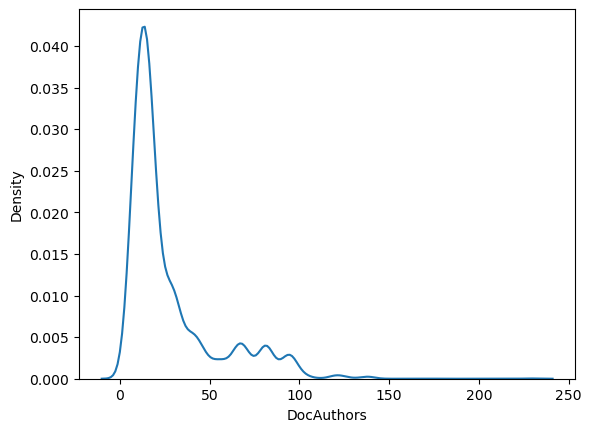

In [145]:
author_items = scraped[mask]["DocAuthors"].apply(eval).explode()
author_item_lens = author_items.str.len()
author_item_lens.describe()
_ = sns.kdeplot(author_item_lens)

In [163]:
author_items[author_items.str.len()>20].value_counts()[20]

41

In [1]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
# text = "This is a sample sentence."
# text = "My name is Hancee."
text = "Hancee V"
doc = nlp(text)
pos_tags = [(token.text, token.pos_) for token in doc]
pos_tags

[('Hancee', 'NOUN'), ('V', 'PROPN')]

In [182]:
strings = ['Lian Buan', 'Lian Buan Is A Senior Investigative Reporter', "Minder Of Rappler'S Justice", 'Human Rights', 'Crime Cluster.']
{string:[token.pos_ for token in nlp(string.upper())] for string in strings}

{'Lian Buan': ['PROPN', 'PROPN'],
 'Lian Buan Is A Senior Investigative Reporter': ['PROPN',
  'PROPN',
  'VERB',
  'DET',
  'ADJ',
  'NOUN',
  'NOUN'],
 "Minder Of Rappler'S Justice": ['PROPN', 'ADP', 'NOUN', 'PART', 'NOUN'],
 'Human Rights': ['ADJ', 'PROPN'],
 'Crime Cluster.': ['NOUN', 'PROPN', 'PUNCT']}

In [138]:

mask = (scraped["DocOutlet"]=="RAPPLER") & (scraped["DocAuthors"].fillna("[]").apply(eval).apply(len)>1)# & (scraped["DocAuthors"].fillna("").apply(list).apply(lambda lst: set(lst)))
scraped[mask]["DocAuthors"].apply(eval).apply(lambda lst: len(lst)!=len(set(lst)))

https://www.rappler.com/nation/luzon/residents-angeles-city-flee-after-violent-demolition-march-2024/                            False
https://www.rappler.com/philippines/former-bucor-official-ricardo-zulueta-suspect-percy-lapid-killing-dead/                      False
https://www.rappler.com/life-and-style/arts-culture/photos-la-trinidad-float-parade-strawberry-festival-2024/                    False
https://www.rappler.com/philippines/marcos-stronger-ties-united-states-japan/                                                    False
https://www.rappler.com/life-and-style/food-drinks/menu-prices-malaysia-secret-recipe-makati-city-branch-one-ayala-mall/         False
                                                                                                                                 ...  
https://www.rappler.com/entertainment/celebrities/kim-seon-ho-shares-filipino-food-acting-wants-try-next/                        False
https://www.rappler.com/nation/weather/severe-tropical-

In [96]:
scraped.loc["https://www.rappler.com/nation/luzon/residents-angeles-city-flee-after-violent-demolition-march-2024/","DocAuthors"]

"['Joann Manabat - Cms', 'Joann Manabat']"

In [ ]:
Fix RAPPLER, GMANEWS, BUSINESSMIRROR

In [74]:
scraped.head()

,DocAuthors,DocPubDate,DocText,DocKeywords,DocOutlet
https://mb.com.ph/2024/3/1/ikea-philippines-reduces-prices-on-more-than-400-products-starting-march-1,NaN,2024-03-01 00:00:00,Offering quality home furnishings at affordabl...,"['better', 'quality', 'ikea', 'starting', 'p25...",MB
https://mb.com.ph/2024/2/6/always-ayala-letter-to-our-fellow-filipinos,NaN,2024-02-06 00:00:00,"Ayala Corporation, the most enduring conglomer...","['190th', 'ayala', 'tribute', 'traces', 'filip...",MB
https://mb.com.ph/2024/3/16/p5-m-marijuana-destroyed-in-kalinga,NaN,2024-03-16 00:00:00,"TABUK CITY, Kalinga – Police destroyed 25,250 ...","['marijuana', 'successful', 'totaling', 'baran...",MB
https://mb.com.ph/2024/3/16/2-communist-rebels-surrender-in-cordillera,NaN,2024-03-16 00:00:00,"CAMP DANGWA, Benguet – Two New People’s Army r...","['conflict', 'force', 'rebels', 'mountain', 'p...",MB
https://www.sunstar.com.ph/davao/origin-of-davao-city-streets-name,['Ralph Lawrence G. Llemit'],NaN,Ponciano Reyes Street\n\nBefore it was renamed...,"['named', 'gil', 'politics', 'origin', 'munici...",SUNSTAR


In [ ]:
df["MentionIdentifier"].nunique()

In [ ]:
df["MentionIdentifier"].nunique()

In [ ]:
df["MentionIdentifier"].values[0]

In [ ]:
df.columns

In [ ]:
(df["MentionTimeDate"] - df["EventTimeDate"]).describe()

In [ ]:
sns.scatterplot(data=df, x="MentionDocTone", y="Confidence")

In [ ]:
content_features = ["SQL", ]
reporting_features = []

In [ ]:
df[["GLOBALEVENTID", "MentionIdentifier"]].nunique()

In [ ]:
df["MentionIdentifier"].value_counts()

In [ ]:
subset = df.query("(MentionIdentifier=='https://www.philippinetimes.com/news/273995609/biden-says-hamas-attacks-on-israel-were-sheer-evil') & (IsRootEvent==1)")
subset.describe()

In [ ]:
df.columns

In [ ]:
df["GLOBALEVENTID"].astype(str) + "_" + df["MentionIdentifier"]

In [ ]:
df.shape